In [2]:
%matplotlib notebook
#Ziyan Zhu
import os
import numpy as np 
import torch
from torch import nn 
import torch.utils.data as td
import torchvision as tv
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import nntools as nt
import time
from VOCdataset import VOCDataset

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

cuda
1.1.0


In [4]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [5]:
labels = ['background',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'aeroplane']
color = {}
for i in range(len(labels)):    
    color[labels[i]] = np.random.random(3)
    
def myimshow(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = image 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    if type(boxes['boxes']) == 'torch.Tensor':
        boxes['boxes'] = boxes['boxes'].to('cpu').numpy()
        boxes['labels'] = boxes['labels'].to('cpu').numpy()

    
    for i in range(len(boxes['labels'])):

        ax.gca().add_patch(patches.Rectangle((boxes['boxes'][i][0],boxes['boxes'][i][1]),boxes['boxes'][i][2]- boxes['boxes'][i][0],boxes['boxes'][i][3]-boxes['boxes'][i][1],edgecolor=color[labels[boxes["labels"][i]]],linewidth=1.5,facecolor='none'))
        ax.annotate(labels[boxes["labels"][i]], xy=(boxes['boxes'][i][2], boxes['boxes'][i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[boxes["labels"][i]]]))
    ax.axis('off') 
   
    return h

def myimshow_score(image, obj, ax = plt):
    image = image.to('cpu').numpy()
    names = obj['labels'].detach().to('cpu').numpy().astype(int)
    boxes = obj['boxes'].detach().to('cpu').numpy()
    scores = obj['scores'].detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 

    if len(scores) == 0:
        ax.axis('off')
        return h
    elif boxes.shape[0] > 0:
        for i in range(len(names)):
            ax.gca().add_patch(patches.Rectangle((boxes[i][0],boxes[i][1]),boxes[i][2]- boxes[i][0],boxes[i][3]-boxes[i][1],edgecolor=color[labels[names[i]]],linewidth = 1.5, facecolor='none'))
            ax.annotate(labels[names[i]]+ ':' + str(scores[i]), xy=(boxes[i][2], boxes[i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names[i]]]))
        ax.axis('off')
    else:
        ax.gca().add_patch( patches.Rectangle((boxes[0],boxes[1]),boxes[2]- boxes[0],boxes[3]-boxes[1],edgecolor=color[labels[names]],linewidth = 1.5,facecolor='none'))
        ax.annotate(labels[names]+ ':' + str(scores), xy=(boxes[2], boxes[1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names]]))
        ax.axis('off') 
   
    return h

class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init() 
        
    def accumulate(self, loss, x, y, d): 
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d) 
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize() 
        return {'loss': loss}

In [6]:
train_set = VOCDataset(dataset_root_dir)
val_set = VOCDataset(dataset_root_dir,mode="val")

# Load the model

In [7]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
# load a model pre-trained 

backbone = tv.models.densenet121(pretrained=True).features
backbone.out_channels = 1024

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
roi_pooler = tv.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model_densenet = FasterRCNN(backbone, num_classes=21,
                            rpn_anchor_generator=anchor_generator,box_roi_pool=roi_pooler)

In [8]:
# create experience
lr = 1e-4
model_densenet = model_densenet.to(device)
params = [p for p in model_densenet.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(model_densenet, train_set, val_set, optimizer, stats_manager,
                     output_dir="faster_rcnn_desnet121", perform_validation_during_training=True)

# Testing

time used:  0.24550604820251465 s
[{'boxes': tensor([[234.8483,  24.9201, 648.3347, 526.1383],
        [227.5613,  45.7847, 489.1505, 437.8922],
        [347.3739,  85.8387, 627.5590, 423.7952]], device='cuda:0'), 'labels': tensor([19, 19, 19], device='cuda:0'), 'scores': tensor([0.9944, 0.6918, 0.2614], device='cuda:0')}]
---------------------------------
{'boxes': tensor([[208.0000,  21.3333, 606.4000, 390.4000]], device='cuda:0'), 'labels': tensor([19], device='cuda:0', dtype=torch.int32)}
---------------------------------
{'boxes': tensor([[234.8483,  24.9201, 648.3347, 526.1383]], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0'), 'labels': tensor([19], device='cuda:0', dtype=torch.int32)}


<IPython.core.display.Javascript object>


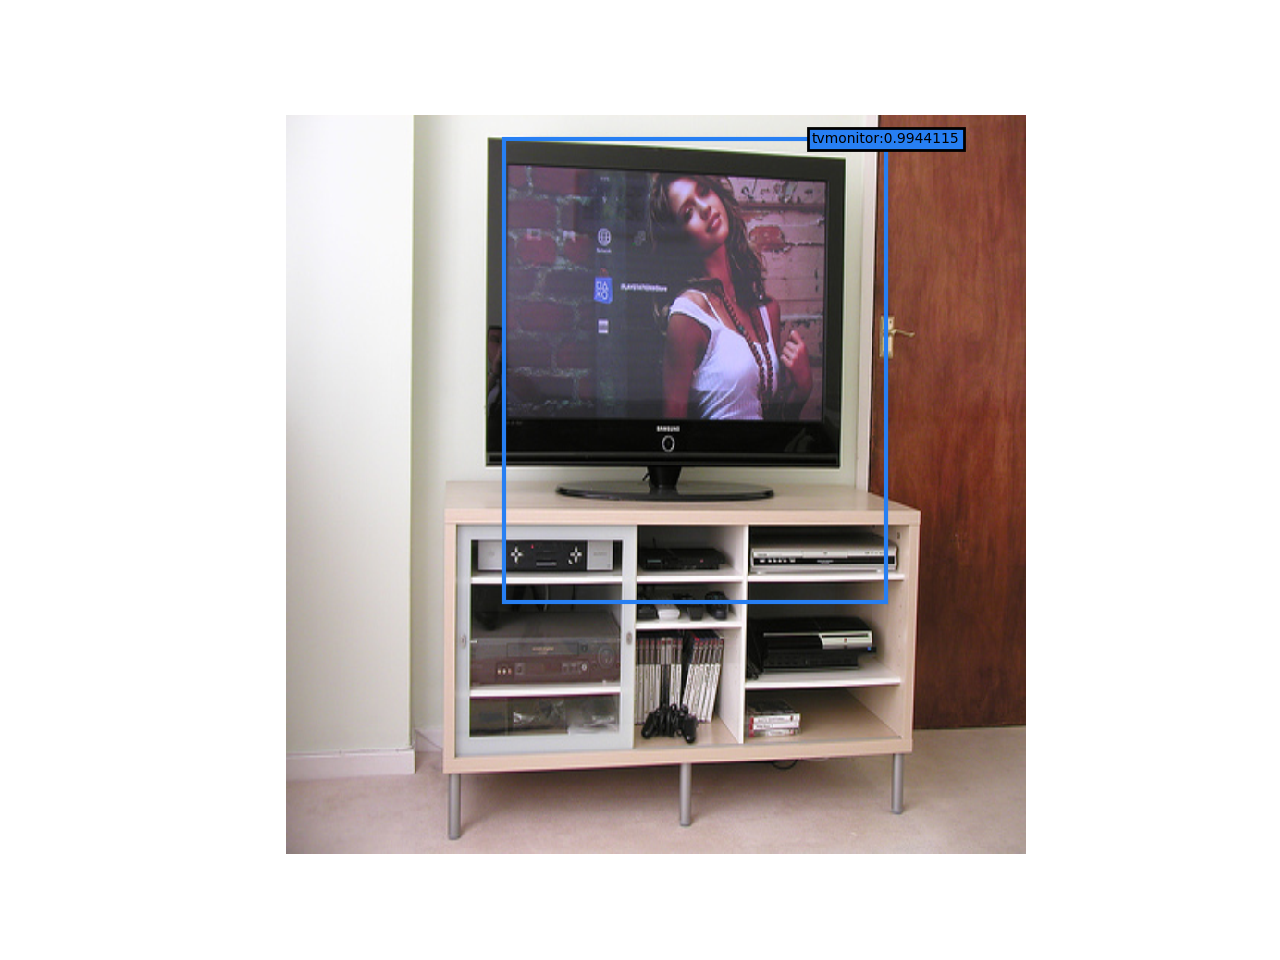

In [13]:
# Output some results (by index of images)
model = exp1.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(1105)
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    tic = time.time()
    prediction = model([images])
    toc = time.time()
    print('time used: ',toc - tic ,'s')
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp1.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0.1)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp1.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.3)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
myimshow_score(images, res)

time used:  0.21681571006774902 s
[{'boxes': tensor([[288.0288, 289.9515, 509.3841, 792.6423],
        [350.6336, 311.3818, 611.3089, 797.7327],
        [ 65.9076, 260.9086, 526.4033, 771.0667],
        [347.7990, 356.3916, 455.7540, 747.6772],
        [302.4735, 343.2881, 425.9646, 741.4891],
        [167.9131, 254.7442, 363.0978, 762.1277],
        [444.8763, 279.8394, 667.5568, 791.7527],
        [449.3745, 289.7864, 678.5698, 761.9404],
        [421.0961, 231.1610, 787.9864, 759.5583],
        [172.6500, 322.9302, 702.0490, 778.6603],
        [457.8930, 220.9350, 759.3554, 730.1784],
        [141.0952, 225.6149, 800.0000, 800.0000],
        [411.0408, 265.4476, 800.0000, 591.5811],
        [427.6541, 180.3633, 785.7085, 727.8794],
        [382.4385, 299.1865, 458.0960, 622.0847],
        [609.9548, 214.7448, 669.5775, 260.3856],
        [ 11.2344, 218.2927, 412.3258, 615.4472],
        [  8.1709, 250.9900, 118.3767, 286.4184],
        [427.7232, 217.4221, 790.7565, 732.8343],
     

<IPython.core.display.Javascript object>


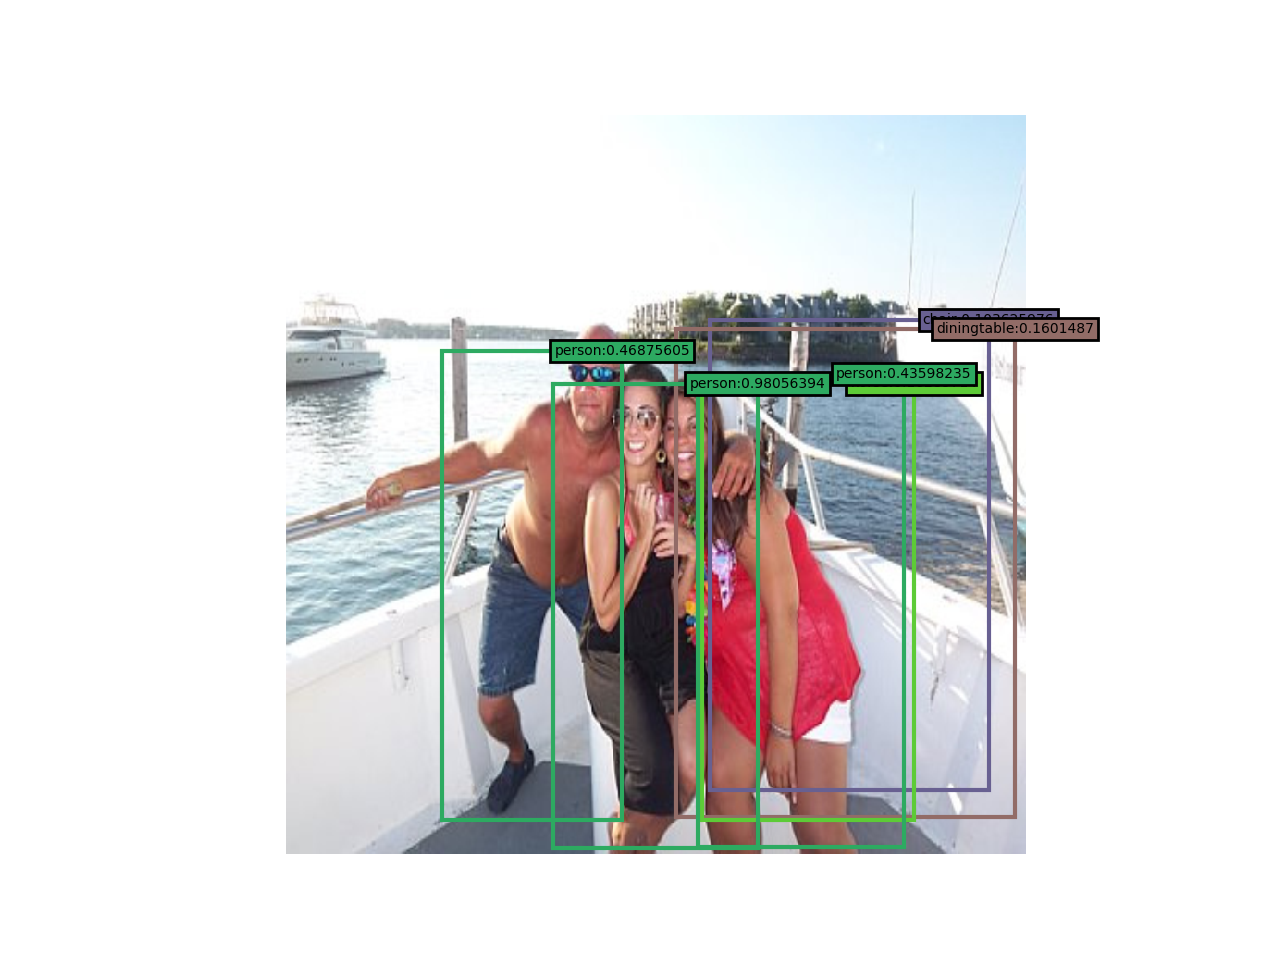

In [12]:
# Output some results (by index of images)
model = exp1.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(2000)
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    tic = time.time()
    prediction = model([images])
    toc = time.time()
    print('time used: ',toc - tic ,'s')
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp1.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0.1)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp1.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.3)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
myimshow_score(images, res)

time used:  0.22927236557006836 s
[{'boxes': tensor([[ 67.8065, 218.4329, 615.7019, 551.0921],
        [108.2371, 230.7177, 606.2844, 406.9465],
        [142.3755, 200.8081, 631.3201, 399.3347],
        [185.8929, 119.2639, 583.6848, 661.4479],
        [300.0525, 114.2815, 486.0729, 430.8847],
        [183.9720,  29.3973, 571.1156, 662.0258],
        [ 45.8195, 113.3689, 633.2169, 526.0159],
        [284.5490, 145.0602, 567.4832, 329.4877]], device='cuda:0'), 'labels': tensor([20, 20,  8, 20,  3,  8,  8,  8], device='cuda:0'), 'scores': tensor([0.1771, 0.1664, 0.1119, 0.0969, 0.0672, 0.0661, 0.0592, 0.0526],
       device='cuda:0')}]
---------------------------------
{'boxes': tensor([[ 78.4000,  69.7095, 601.6000, 730.2905]], device='cuda:0'), 'labels': tensor([20], device='cuda:0', dtype=torch.int32)}
---------------------------------
{'boxes': tensor([[142.3755, 200.8081, 631.3201, 399.3347],
        [ 67.8065, 218.4329, 615.7019, 551.0921]], device='cuda:0'), 'scores': tensor([0.11

<IPython.core.display.Javascript object>


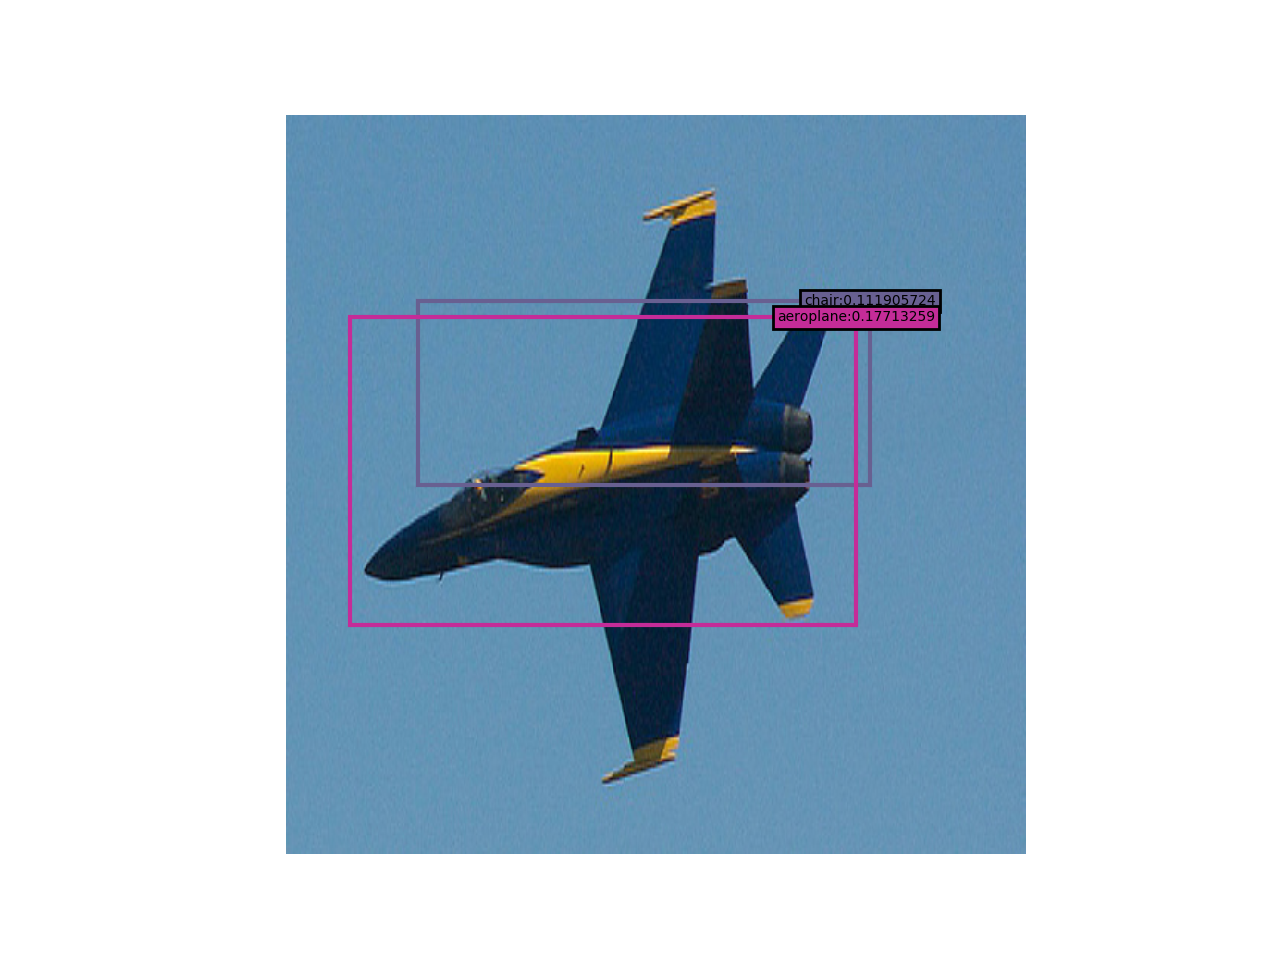

In [11]:
# Output some results (by image name)
model = exp1.net
model.eval()
with torch.no_grad():
    images, targets = val_set.__getitem__(2000,'2008_001719')
    images = images.to(device)
    #img = images.clone()
    targets['boxes'] = targets['boxes'].to(device)
    targets['labels'] = targets['labels'].to(device)

    tic = time.time()
    prediction = model([images])
    toc = time.time()
    print('time used: ',toc - tic ,'s')
    
    print(prediction)
    print("---------------------------------")
    print(targets)
    print("---------------------------------")
    
    res = {'boxes':torch.Tensor([]).to(device),'scores':torch.Tensor([]).to(device),'labels':torch.Tensor([]).to(device).int()}
    objs = set(prediction[0]['labels'].to('cpu').numpy())
    if len(prediction[0]['boxes'].shape) > 1:
        prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'] = exp1.myfilter(prediction[0]['boxes'] , prediction[0]['scores'], prediction[0]['labels'], threshold = 0.1)
    
        for k in objs:
            obj_idx = prediction[0]['labels'] == k

            idx = exp1.nms(prediction[0]['boxes'][obj_idx], prediction[0]['scores'][obj_idx], threshold=0.3)

            res['boxes'] = torch.cat((res['boxes'], prediction[0]['boxes'][obj_idx][idx]), 0)
            res['scores'] = torch.cat((res['scores'], prediction[0]['scores'][obj_idx][idx]), 0)
            res['labels'] = torch.cat((res['labels'], prediction[0]['labels'][obj_idx][idx].int()), 0)
    print(res)
myimshow_score(images, res)